In [10]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [11]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-01-01,26.149805
1,AAPL,2015-02-01,28.671928
2,AAPL,2015-03-01,27.882059
3,AAPL,2015-04-01,28.043394
4,AAPL,2015-05-01,29.192923
...,...,...,...
915,NVDA,2024-03-01,90.344337
916,NVDA,2024-04-01,86.394905
917,NVDA,2024-05-01,109.624001
918,NVDA,2024-06-01,123.529854


In [12]:
Y_df['Z-Score'] = Y_df.groupby('unique_id')['y'].transform(lambda x: zscore(x, nan_policy='omit'))
data = Y_df[Y_df['unique_id'] == 'AMZN']
data

,unique_id,ds,y,Z-Score
115,AMZN,2015-01-01,17.726500,-1.563104
116,AMZN,2015-02-01,19.007999,-1.538022
117,AMZN,2015-03-01,18.605000,-1.545910
118,AMZN,2015-04-01,21.089001,-1.497291
119,AMZN,2015-05-01,21.461500,-1.490000
...,...,...,...,...
225,AMZN,2024-03-01,180.380005,1.620458
226,AMZN,2024-04-01,175.000000,1.515157
227,AMZN,2024-05-01,176.440002,1.543342
228,AMZN,2024-06-01,193.250000,1.872358


In [17]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2.5, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom

,unique_id,ds,y
0,AAPL,2015-01-01,26.149805
1,AAPL,2015-02-01,28.671928
2,AAPL,2015-03-01,27.882059
3,AAPL,2015-04-01,28.043394
4,AAPL,2015-05-01,29.192923
...,...,...,...
915,NVDA,2024-03-01,61.519058
916,NVDA,2024-04-01,61.519058
917,NVDA,2024-05-01,61.519058
918,NVDA,2024-06-01,61.519058


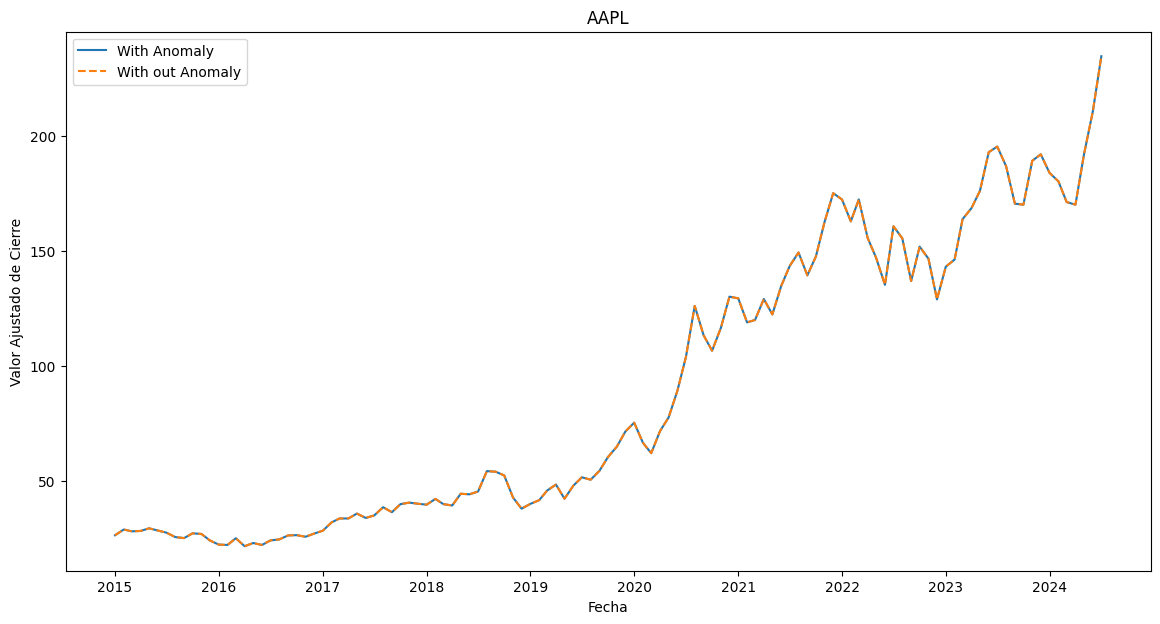

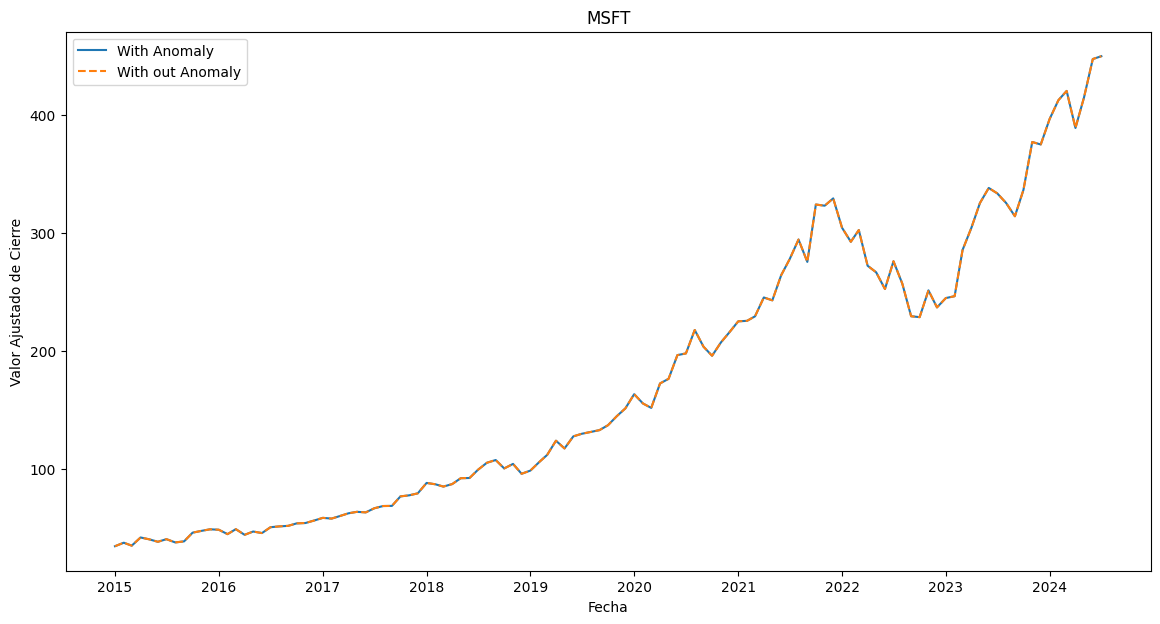

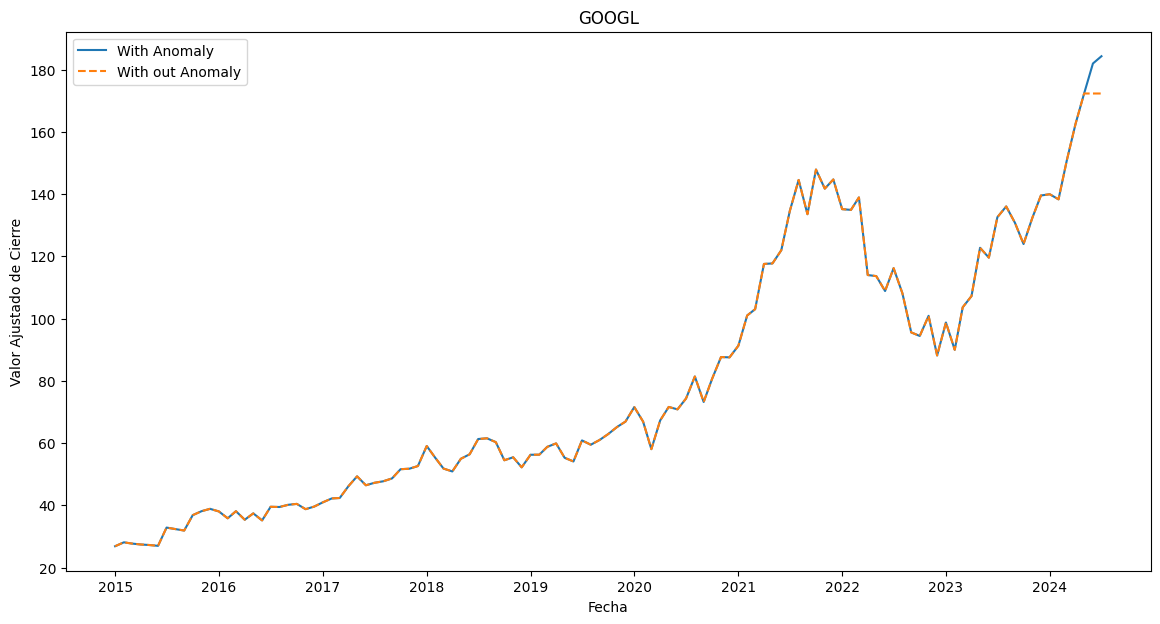

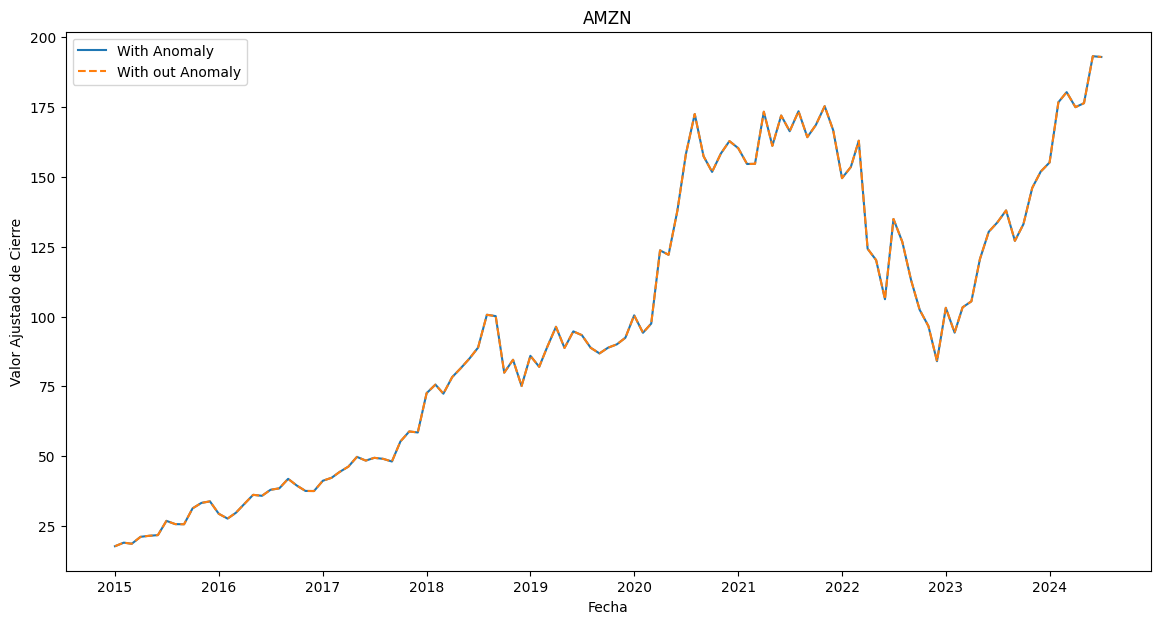

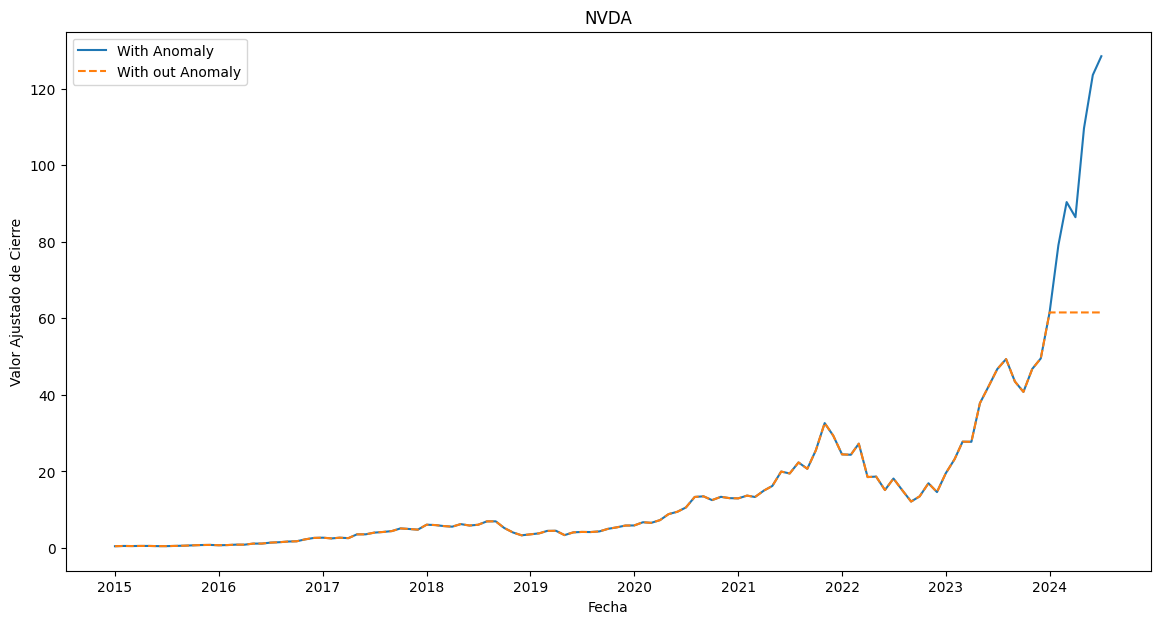

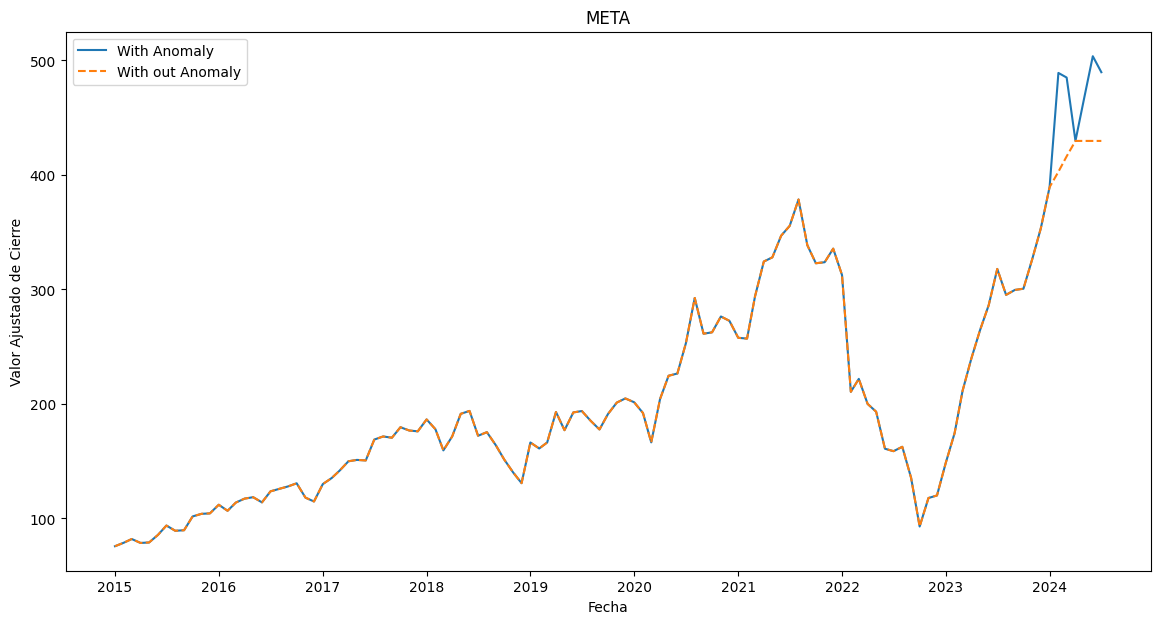

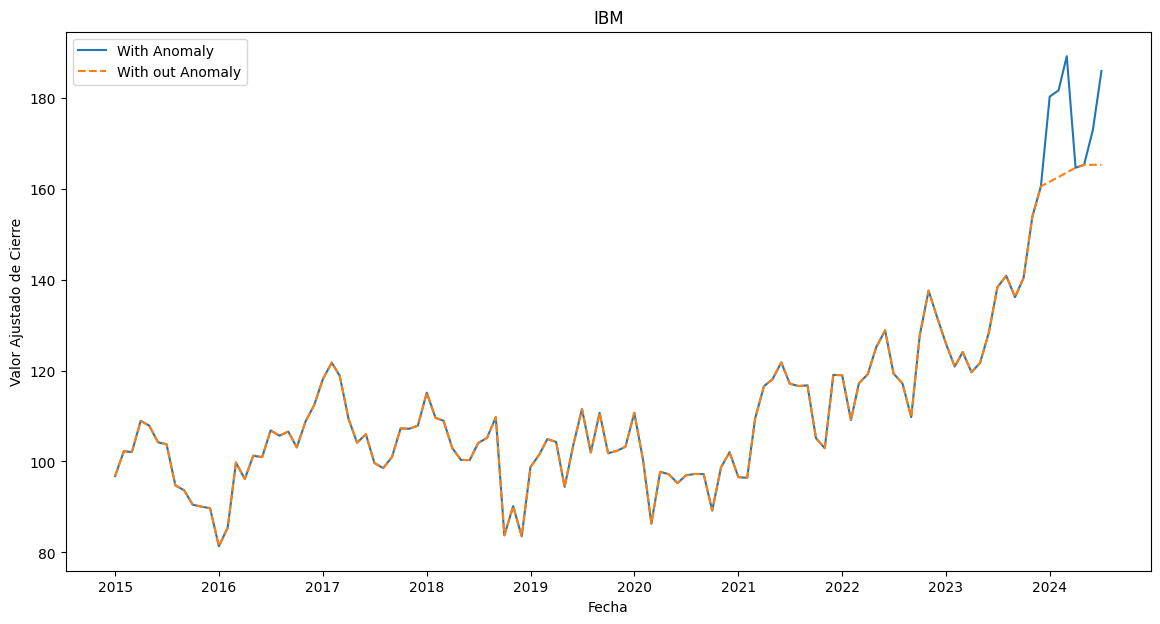

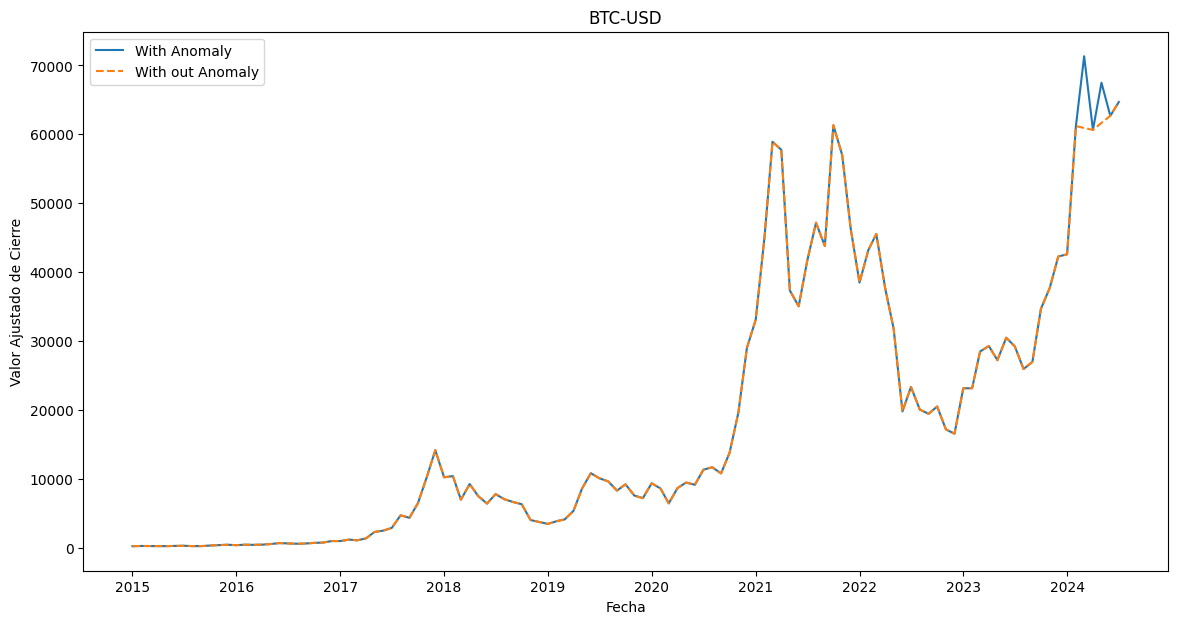

In [18]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()


In [19]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [20]:
season_length = 12 # Define season length as 12 months for monthly data
horizon = 1 # Forecast horizon is set to 1 month

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [21]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,,,
AAPL,2024-07-31,234.737000,186.877548,237.709229,236.986374,242.713486,234.548767
AMZN,2024-07-31,192.979996,138.009995,192.979996,194.314560,194.335831,197.922668
BTC-USD,2024-07-31,64694.191406,25931.472656,65071.605469,64693.988281,65142.503906,64035.363281
GOOGL,2024-07-31,172.302246,136.013901,172.302246,173.396851,173.534424,176.903442
IBM,2024-07-31,165.209991,140.836899,165.209991,165.208694,165.628479,163.483887


In [22]:
cv_df = sf.cross_validation(df=ts_not_anom, h=horizon, n_windows=5, step_size=horizon, level=[99])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-99,Naive-hi-99,SeasonalNaive,SeasonalNaive-lo-99,SeasonalNaive-hi-99,AutoARIMA,...,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2024-03-01,2024-02-01,171.247726,180.275131,159.370834,201.179428,163.802307,88.182266,239.422348,180.275131,...,201.179428,181.236435,142.467468,220.005402,185.876450,169.628067,202.455414,184.646057,154.718353,214.249039
AAPL,2024-04-01,2024-03-01,170.099289,171.247726,150.320892,192.174561,168.550491,93.288651,243.812332,171.247726,...,192.174561,172.173233,135.442917,208.903564,169.671234,153.557404,186.112946,174.510803,144.324890,201.732941
AAPL,2024-05-01,2024-04-01,191.989594,170.099289,149.265045,190.933533,176.070099,101.184448,250.955750,170.099289,...,190.933533,171.016525,134.702988,207.330078,170.566788,154.758850,186.696350,170.460938,141.466904,199.543854
AAPL,2024-06-01,2024-05-01,210.619995,191.989594,170.575180,213.404007,192.945328,118.319695,267.570953,191.989594,...,213.404022,192.991394,151.785324,234.197449,195.699371,179.179916,212.554916,191.231613,161.480377,220.252670
AAPL,2024-07-01,2024-06-01,234.737000,210.619995,188.827820,232.412170,195.412201,121.016579,269.807831,210.306442,...,231.908722,212.483688,167.048569,257.918793,223.774094,206.181000,241.725159,214.352448,185.330338,243.880188


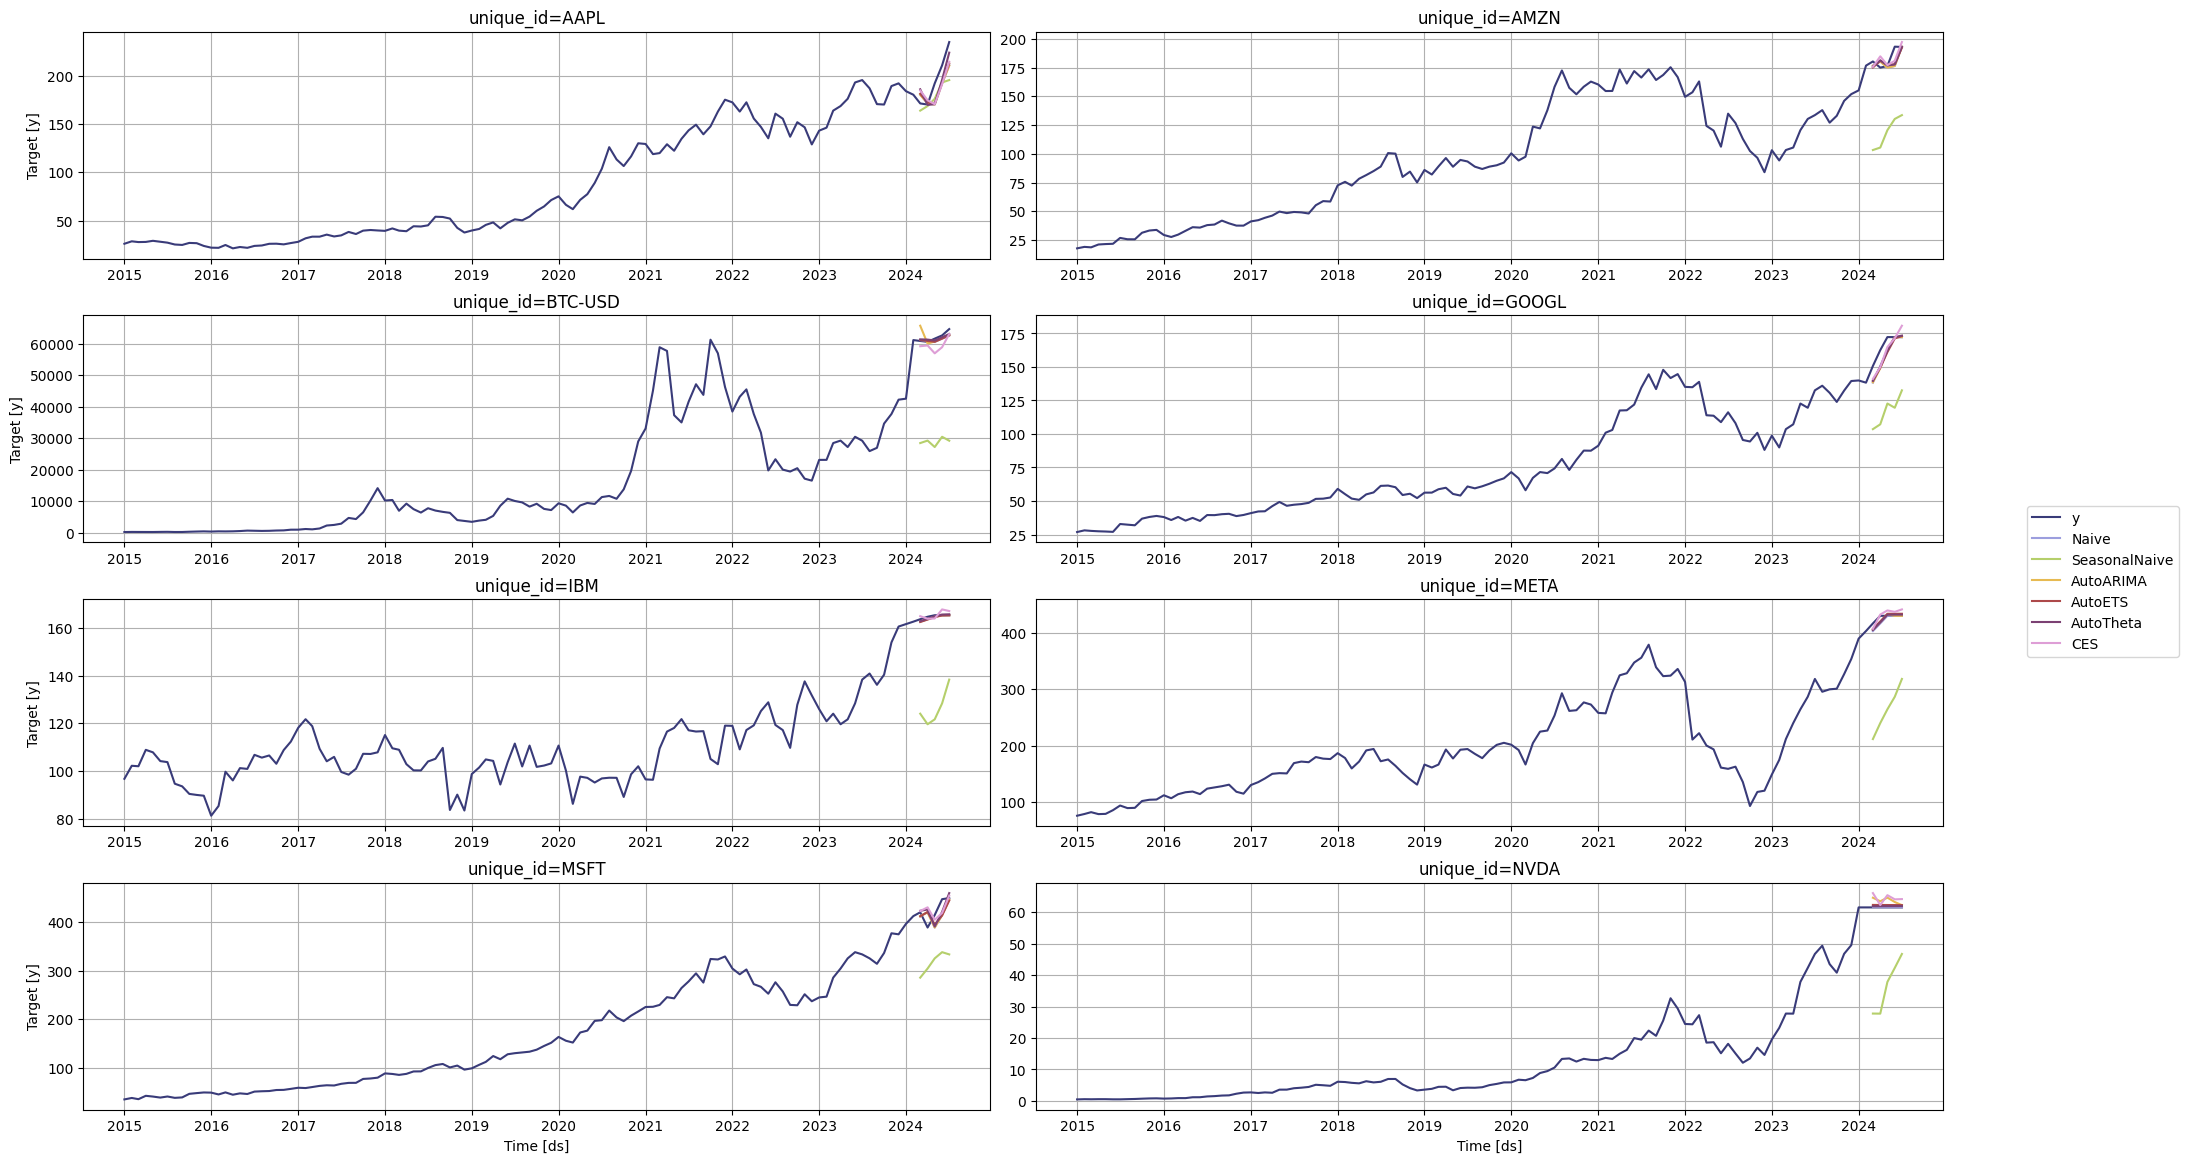

In [23]:
StatsForecast.plot(ts_not_anom, cv_df.drop(['cutoff', 'y'], axis=1))

In [24]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [25]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [26]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [27]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [28]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-16 21:03:42,487 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 72f56ea9609e37b758b9f2ad6421e5aa initialized by task ('shuffle-transfer-72f56ea9609e37b758b9f2ad6421e5aa', 7) executed on worker tcp://127.0.0.1:50200
2024-07-16 21:03:45,465 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 72f56ea9609e37b758b9f2ad6421e5aa deactivated due to stimulus 'task-finished-1721156625.461966'


,unique_id,cutoff,metric,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
0,AAPL,2024-05-01,mse,347.091858,312.39386,347.091858,310.767578,222.625015,375.909363
1,AAPL,2024-05-01,mae,18.630402,17.674667,18.630402,17.628601,14.920624,19.388382
2,AAPL,2024-05-01,smape,9.254823,8.75926,9.254823,8.735434,7.344284,9.649523
3,BTC-USD,2024-04-01,mse,1041866.75,1185969920.0,827183.125,1041810.9375,333921.46875,21796278.0
4,BTC-USD,2024-04-01,mae,1020.71875,34437.914062,909.496094,1020.691406,577.859375,4668.648438


In [29]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  SeasonalNaive     AutoARIMA        AutoETS  \
cutoff     metric                                                              
2024-02-01 mae          41.02346     4122.92041    611.142578      40.674366   
           mse       9915.350586    131546040.0    2929956.25    9775.700195   
           smape        2.754801      46.863289      4.162596       2.888428   
2024-03-01 mae         43.118706    3980.948486     78.484917       43.24147   
           mse      10020.214844    123001096.0  39731.582031   10023.208984   
           smape        2.909263      43.720654      3.421293       3.210037   
2024-04-01 mae        135.019379    4360.164062    121.830917     134.802261   
           mse     130388.242188    148251696.0  103554.84375  130346.859375   
           smape        3.397826      38.410378       4.06679       3.473581   
2024-05-01 mae         136.09082    4080.355713    113.178452     136.591522   
           mse     130444.632812    129618536.0    87512.4375  130469.867188   
           smape        3.444113      35.362164      3.749898       3.637293   
2024-06-01 mae        255.333191    4483.996094    234.255798     256.136871   
           mse         508054.25    157216800.0   425782.6875   508099.03125   
           smape        1.833333      32.602211      1.985886       2.129031   

                      AutoTheta            CES  
cutoff     metric                               
2024-02-01 mae        69.997192     214.268524  
           mse     33095.167969     348033.375  
           smape       2.963346       3.800186  
2024-03-01 mae        97.632172     153.055847  
           mse     63568.621094  166177.984375  
           smape       3.239284       3.807778  
2024-04-01 mae        79.538147     590.358093  
           mse     41881.175781      2724625.0  
           smape       3.289929       4.511922  
2024-05-01 mae        80.097542     477.610687  
           mse     42379.023438    1756177.625  
           smape       3.002201       4.570222  
2024-06-01 mae       199.078583     204.204895  
           mse     307050.59375   312068.78125  
           smape       1.454157        3.43924

<Axes: xlabel='error', ylabel='model'>

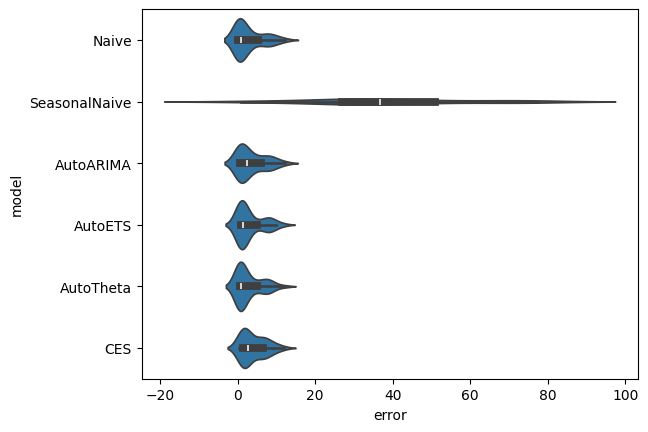

In [30]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

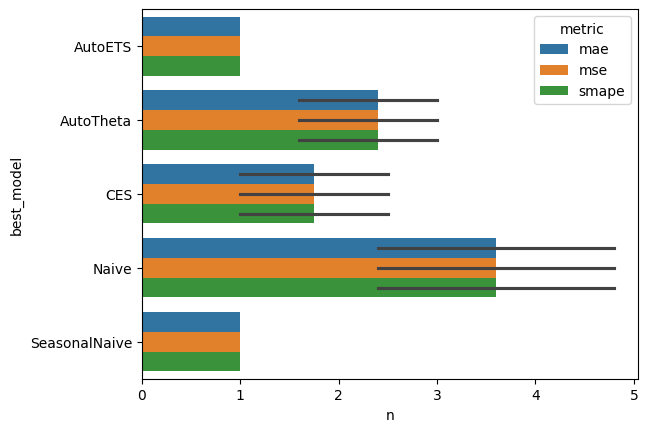

In [31]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')